# Modelación de intervenciones para el control de la tuberculosis en prisiones

##### Alliance meeting Paraguay EUSAT-RCS consortium, 2024

Diseñado por Juan F. Vesga, 2024 

Durante esta sesión examinaremos el impacto de las intervenciones dirigidas a diferentes pasos en la cascada de atención de la TB, para un escenario hipotético con altos niveles de transmisión en las prisiones. Para este propósito, utilizaremos un modelo de transmisión de TB pre-codificado. Nuestro modelo está codificado en R y todas las funciones disponibles se encuentran en las carpetas con este cuaderno. La práctica está diseñada para una audiencia más amplia (¡es decir, no es necesario ser fluido en R!) y se centra en comprender la dinámica de la TB bajo diferentes intervenciones. Sin embargo, también debería ser un buen recurso para aquellos que ya están familiarizados con el lenguaje de programación R y una puerta de entrada introductoria para aquellos que tienen como objetivo aprender más sobre el modelado de TB en R.

**El modelo**

Tómese un momento para comprender la estructura del modelo. Si desea explorar cómo se codifica este modelo en R, abra el archivo "R/TB_prison.r" en el directorio.

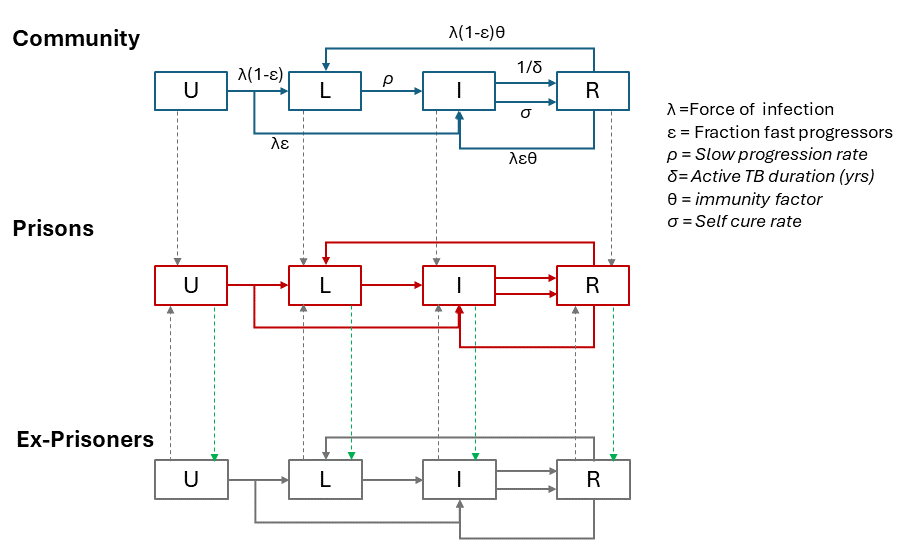

Este modelo tiene tres entornos de transmisión separados: la comunidad, las prisiones y la población de ex-prisioneros. Las tres dimensiones replican el mismo enfoque mecanicista para la transmisión de TB. Es decir, las personas no infectadas (U) se infectan a una tasa lambda que está definida por una tasa de contacto efectiva per cápita (beta) y la prevalencia de individuos infectados por TB en cada punto en el tiempo. Una vez infectadas, las personas pueden moverse hacia el compartimento de infección de TB latente (L) o avanzar rápidamente hacia el compartimento de TB activa (I). Las transiciones de L a I ocurren a una tasa mucho más lenta que refleja la fuente remota de incidencia de TB conocida en la literatura. La TB activa tiene una duración promedio de 3 años, después de lo cual las personas pueden morir por la enfermedad o recuperarse. El compartimento recuperado (R) permite la reinfección y también la recaída. El proceso de reinfección desde R está mediado por alguna forma de inmunidad adquirida a través de la infección previa.  

**Parte I: Calibrar un modelo de referencia**

*Epidemiología de la TB en el país "X"*

Trabajaremos bajo la suposición de un país no identificado "X" que se informa que tiene una carga de TB (incidencia de TB) de 190 por cada 100,000 individuos y una incidencia de TB en prisiones de 990 por cada 100,000. La población encarcelada es ~0.5% de la población, y el tiempo promedio de sentencia es ~2.5 años. Se ha estimado que la tasa de encarcelamiento es de 200 por cada 100,000 y se piensa que es 5 veces mayor para los reincidentes.

Una evaluación de la cascada de atención de la TB en el país "X" ha mostrado que la mayoría de las personas tardan alrededor de 1 año entre desarrollar síntomas de TB y buscar atención médica. De los que buscan atención, ~80% son diagnosticados y de los diagnosticados, el 89% recibe tratamiento.

Sin embargo, dentro del sistema penitenciario, esta cascada es menos eficiente, y se ha estimado que solo el 62% de los casos son diagnosticados y de los diagnosticados, solo el 70% recibe tratamiento. Actualmente no hay un programa de terapia preventiva en el país "X".

Utilizará el código disponible aquí para intentar reproducir la carga de TB en el país "X" utilizando la estructura del modelo detallado anteriormente. En cada paso, se le pedirá que ejecute 'bloques' de código. En la mayoría de los casos, este código resultará en una nueva figura para que la examine. En otros casos, ejecutaremos código para preparar nuestro análisis o cargar nuestra entrada.

A) En el siguiente código vamos a crear parámetros de entrada para nuestro modelo de TB. Siguiendo la descripción de los indicadores epidémicos de TB en el país "X", intente completar la lista de parámetros ingresando valores numéricos para todos los campos donde vea "??", en la parte superior del bloque de código. Luego, ejecute el código.


In [ ]:
# Parámetros del modelo desconocidos (complete sus respuestas)
pDx      <- ??            # Probabilidad de ser diagnosticado una vez que se busca atención
pTx_p    <- ??            # Probabilidad de recibir un tratamiento correcto si se diagnostica (prisiones)


# Parámetros del modelo conocidos
T.lfx    <- 72              # Esperanza de vida
T.dur    <- 3               # Duración del período infeccioso (años)
mu       <- 1/T.lfx         # Tasa de mortalidad de fondo
mu_tb    <- 0.5*1/T.dur     # Tasa de mortalidad de TB
fast     <- 0.1             # Fracción que progresa rápidamente a TB activa
imm      <- 0.5             # Declinación de la infectividad (inmunidad parcial)
relapse  <- 0.005           # Tasa de recaída
r_incar  <- 200/1e5         # Tasa de encarcelamiento
r_reincar<- 1000/1e5        # Tasa de reincidencia
r_release<- 1/2.5           # Tasa de liberación (1/tiempo medio) 
RRc      <- 2               # Proporción de aumento de contacto en prisión en relación con la comunidad
RRbreak_p<- 1               # Aumento relativo en la reactivación de TB en prisión
RRbreak_x<- 2               # Aumento relativo en la reactivación de TB en ex-prisión
T.rTx    <- 0.5             # Duración del tratamiento de 6 meses
care_seeking<-1             # Tasa de búsqueda de atención (1 año)
care_seeking_p<-1             # Tasa de búsqueda de atención (1 año) en prisiones
care_seeking_x<-1             # Tasa de búsqueda de atención (1 año) en ex-prisioneros

# Parámetros de la comunidad
beta     <- 5               # Tasa de transmisión por cápita
break_in <- 0.1*1/T.lfx     # Tasa de transición de latente a enfermedad activa
selfcure <- 0.5*1/T.dur     # Tasa de curación espontánea
pTx  <- 0.89                # Probabilidad de recibir un tratamiento correcto si se diagnostica

# Parámetros de prisiones
beta_p     <- beta*RRc           # Tasa de transmisión por cápita en prisiones
break_in_p <- break_in*RRbreak_p # Tasa de transición de latente a enfermedad activa en prisiones
fast_p     <- 0.1                # Fracción que progresa rápidamente a TB activa en prisiones
selfcure_p <- 0.5*1/T.dur        # Tasa de curación espontánea en prisiones
pDx_p  <- 0.62                   # Probabilidad de ser diagnosticado una vez que se busca atención (prisiones)

# Parámetros de ex-prisioneros
beta_x     <- beta               # Tasa de transmisión por cápita en ex-prisioneros
break_in_x <- break_in*RRbreak_x # Tasa de transición de latente a enfermedad activa en ex-prisioneros
selfcure_x <- 0.5*1/T.dur        # Tasa de curación espontánea en ex-prisioneros
pDx_x  <- pDx                    # Probabilidad de ser diagnosticado una vez que se busca atención
pTx_x  <- pTx                    # Probabilidad de recibir un tratamiento correcto si se diagnostica

# Condiciones iniciales
N  <- 1                    # Población total igual a la unidad 
I0 <- 1e-6                 # Semilla de TB en el tiempo 0
Np  <- 0.005               # Población total de prisiones (0.5% de la población total) 
I0p <- Np*1e-6*10        # Semilla de TB en el tiempo 0 en prisiones
Nx  <- Np*2              # Población total de ex-prisioneros 
I0x <- Nx*1e-6*5        # Semilla de TB en el tiempo 0 en ex-prisioneros

**Carga de bibliotecas y funciones necesarias**

Ejecute el bloque de código para cargar las bibliotecas R necesarias y las funciones para nuestro análisis. Si tiene tiempo, explore la ubicación del archivo "R/TB_prison.r", que es donde se ha codificado el modelo de TB descrito anteriormente. Ejecutaremos esta función varias veces durante esta sesión.  

In [ ]:
# Cargue las funciones necesarias
source("R/TB_prison.r")
source("R/useful_functions.r")

# Cargue las librerias necesarias
library(deSolve)
library(gridExtra)
library(ggplot2)
library(reshape)

B) Ejecute el siguiente bloque de código para simular una epidemia de TB en el país X. 

Ahora que ha creado sus entradas de parámetros y ha cargado las funciones necesarias, verá las trayectorias de incidencia de TB para las tres subpoblaciones de interés.

Pero las trayectorias anteriores NO concuerdan con la incidencia descrita anteriormente para el pais X.

C) Cambie los valores de 'beta' y 'RRbreak_p' en el bloque de código a continuación y ejecute hasta que la trayectoria simulada se ajuste al punto de datos.

In [ ]:
# Calibrar parámetros de transmisión y
beta     <- 7  # Tasa de transmisión por cápita en la comunidad
RRbreak_p<- 3 # Aumento relativo en la reactivación de TB en prisión


# Crear lista de parámetros para pasar a la función del modelo
params <- c(
  break_in = break_in,
  break_in_p = break_in * RRbreak_p,
  break_in_x = break_in_x,
  selfcure = selfcure, 
  selfcure_p = selfcure_p, 
  selfcure_x = selfcure_x, 
  mu = mu, 
  mu_tb = mu_tb,
  beta = beta,
  beta_p =  beta * RRc, 
  fast = fast, 
  fast_p = fast_p, 
  imm = imm, 
  relapse = relapse,
  r_incar = r_incar,
  r_reincar = r_reincar,
  r_release = r_release) 

# Crear vectores de tiempo para la simulación
t.intervention <- 400      # años de simulación
t.scale        <- 3        # Escalamiento del tiempo de las intervenciones
times <- seq(0, t.intervention, by = 1)          # escala de tiempo
t.interv   <- c(t.intervention-40, (t.intervention-30)+t.scale)

# Construir cascada de atención inicial
cascade <- pDx * pTx * (1 / (care_seeking + T.rTx))
cascade_x <- pDx_x * pTx_x * (1 / (care_seeking + T.rTx))
cascade_p <- pDx_p * pTx_p * (1 / (care_seeking + T.rTx))

params_base <- params
params_base["selfcure"] <- selfcure + cascade
params_base["selfcure_x"] <- selfcure_x + cascade_x
params_base["selfcure_p"] <- selfcure_p + cascade_p

# Crear dataframe con condiciones iniciales (t0)
xstart <- data.frame(
  U = N - I0 - Np - Nx,
  L = 0,
  I = I0,  
  R = 0,
  Ux = Nx - I0x,
  Lx = 0,
  Ix = I0x,  
  Rx = 0,
  Up = Np - I0p,
  Lp = 0,
  Ip = I0p,  
  Rp = 0,
  Incidence = 0, 
  Irecent = 0, 
  Iremote = 0,
  Incidence_x = 0, 
  Irecent_x = 0, 
  Iremote_x = 0,
  Incidence_p = 0, 
  Irecent_p = 0, 
  Iremote_p = 0)  


out0 <- get_intervention(xstart, 
                         params_base,
                         params, 
                         times, 
                         t.interv, 
                         "Initial", 
                         NA) 

# Gráfica

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 300, warn = -1)  # Opciones de gráficos para este notebook (solo una vez)
grid.arrange(out0$incbase_c, out0$incbase_p, out0$inc_all, nrow = 2)


Una vez que haya calibrado los parámetros de entrada, ahora está listo para pasar a la parte II donde introduciremos intervenciones. Ejecute el bloque a continuación para ver su modelo base calibrado.

In [ ]:
# Simulacion 0 0 ------------------------------------------------------------

# Proyeccion de referencia (linea base)
int_name   <- "Baseline"

#Condiciones iniciales del modelo (2024)
sfin       <- tail(out0$out,1)
times_new  <- seq(t.intervention, t.intervention+25 , by=1)
params_0<-params_base

data0<-get_intervention(sfin, 
                        params_0, 
                        NA,
                        times_new,
                        NA, 
                        int_name, 
                        NA) 


grid.arrange(data0$inc_c ,data0$inc_p,data0$inc_x,data0$reduc, nrow=2 )
inc_p_0<-data0$data$Incidence_p[1]

**Parte II: Intervenciones para controlar la carga de TB en prisiones**

En la Parte II, se introducen intervenciones para abordar la alta carga de TB en las prisiones. El objetivo es examinar escenarios de modelado en los cuales la carga de TB en las prisiones pueda reducirse en un 70% en los próximos 10 años. En las siguientes secciones de código, se presentará una serie de intervenciones de manera secuencial, es decir, se verá el efecto acumulativo de una intervención sobre la anterior.

La primera intervención que se introducirá es mejorar la probabilidad de diagnóstico de TB en las prisiones hasta el 95%.

Al ejecutar el código y explorar la figura de salida, se observarán las trayectorias de incidencia para las tres poblaciones y un gráfico de barras con las reducciones relativas de incidencia en los próximos 10 años. También se verá una línea discontinua en el gráfico de incidencia de los prisioneros. Esto indica el objetivo al cual se desea reducir la incidencia. 

In [ ]:
# Simulación 1 Diagnóstico ----------------------------------------------------

# Una intervención que simula una mejora en el diagnóstico en las prisiones
int_name   <- "Diagnosis"

# Actualizar marco de datos de resultados de parámetros para agregar nuevos resultados
params_1 <- params_0
data_stub <- data0$data
t.interv <- c(times_new[2], times_new[2] + t.scale)

# Cambiar parámetros para la intervención
pDx_p  <- 0.95   # Probabilidad de ser diagnosticado una vez que se busca atención

cascade_p <- pDx_p * pTx_p * (1 / (care_seeking_p + T.rTx))

params_1["selfcure_p"] <- selfcure_p + cascade_p

data1 <- get_intervention(sfin, 
                          params_1, 
                          params_0,
                          times_new,
                          t.interv, 
                          int_name, 
                          data_stub) 

p1 <- data1$inc_p +
  # Objetivo
  geom_hline(yintercept = inc_p_0 * (1 - 0.7), linetype = "dashed", color = "black", linewidth = 1) +
  annotate("text", x = 2026, y = inc_p_0 * (1 - 0.7), label = "Objetivo", vjust = -0.5)

grid.arrange(data1$inc_c, p1, data1$inc_x, data1$reduc, nrow = 2)


La siguiente intervención simula una mejora en la probabilidad de tratamiento de TB (después de haber recibido un diagnóstico previo) de hasta el 95% en las prisiones

In [ ]:
# Simulación 2 Tratamiento ----------------------------------------------------

# Una intervención que simula una mejora en el tratamiento en las prisiones
int_name   <- "Treatment"

# Actualizar marco de datos de resultados de parámetros para agregar nuevos resultados
params_2 <- params_0
data_stub <- data1$data

# Cambiar parámetros para la intervención
pDx_p  <- 0.95   # Probabilidad de ser diagnosticado una vez que se busca atención
pTx_p  <- 0.95   # Probabilidad de recibir un tratamiento correcto si se diagnostica

cascade_p <- pDx_p * pTx_p * (1 / (care_seeking_p + T.rTx))

params_2["selfcure_p"] <- selfcure_p + cascade_p

data2 <- get_intervention(sfin, 
                          params_2, 
                          params_0,
                          times_new,
                          t.interv, 
                          int_name, 
                          data_stub) 

p1 <- data2$inc_p +
  # Objetivo
  geom_hline(yintercept = inc_p_0 * (1 - 0.7), linetype = "dashed", color = "black", linewidth = 1) +
  annotate("text", x = 2026, y = inc_p_0 * (1 - 0.7), label = "Objetivo", vjust = -0.5)

grid.arrange(data2$inc_c, p1, data2$inc_x, data2$reduc, nrow = 2)


A continuación, queremos ver el impacto de reducir el retraso en el tiempo entre el desarrollo de síntomas y el acceso a servicios de diagnóstico y tratamiento. Actualmente, este retraso es de 1 año, y nos gustaría reducirlo a 6 meses (es decir, un 50%). En términos prácticos, esto se lograría reduciendo las barreras para acceder a los servicios e incrementando la demanda de servicios de TB (por ejemplo, campañas de concientización, aumento de puntos de acceso).

In [ ]:
# Simulación 3 Mejora de la búsqueda de atención ----------------------------------

int_name   <- "Fast access"

# Actualizar marco de datos de resultados de parámetros para agregar nuevos resultados
params_3 <- params_2
data_stub <- data2$data

# Cambiar parámetros para la intervención
care_seeking_p <- 1 * (1 - 0.5)    # Retraso de tiempo (años) entre el desarrollo de síntomas y la búsqueda de atención
pDx_p  <- 0.95     # Probabilidad de ser diagnosticado una vez que se busca atención
pTx_p  <- 0.95     # Probabilidad de recibir un tratamiento correcto si se diagnostica

cascade_p <- pDx_p * pTx_p * (1 / (care_seeking_p + T.rTx))

params_3["selfcure_p"] <- selfcure_p + cascade_p

data3 <- get_intervention(sfin,
                          params_3, 
                          params_0,
                          times_new,
                          t.interv, 
                          int_name, 
                          data_stub) 

p1 <- data3$inc_p +
  # Objetivo
  geom_hline(yintercept = inc_p_0 * (1 - 0.7), linetype = "dashed", color = "black", linewidth = 1) +
  annotate("text", x = 2026, y = inc_p_0 * (1 - 0.7), label = "Objetivo", vjust = -0.5)

grid.arrange(data3$inc_c , p1, data3$inc_x, data3$reduc, nrow = 2 )


Ahora que se ha intervenido en toda la cascada de atención (buscar atención hasta tratamiento), miramos aguas arriba hacia las estrategias de prevención de la TB. El siguiente fragmento de código introduce una intervención que tiene como objetivo detectar al 40% de la población de personas encarceladas con LTBI, tratar al 80% de esos casos positivos con un régimen de TPT de 3 meses (es decir, 3HP) para una eficacia asumida del régimen del 70%.

Nota: observe cómo introducimos esta intervención modificando la 'tasa de ingreso de la reactivación'.

In [ ]:
# Simulación 4 Prevención -------------------------------------------------

# Una intervención que simula el tratamiento de la LTBI
int_name <- "Prevention"

# Actualizar marco de datos de resultados de parámetros para agregar nuevos resultados
params_4 <- params_3
data_stub <- data3$data

# Cambiar parámetros para la intervención
care_seeking_p <- 1 * (1 - 0.75)    # Retraso de tiempo (años) entre el desarrollo de síntomas y la búsqueda de atención
pDx_p  <- 0.95     # Probabilidad de ser diagnosticado una vez que se busca atención
pTx_p  <- 0.95     # Probabilidad de recibir un tratamiento correcto si se diagnostica

cascade_p <- pDx_p * pTx_p * (1 / (care_seeking_p + T.rTx))

params_4["selfcure_p"] <- selfcure_p + cascade_p
params_4["break_in_p"] <- break_in_p * (1 - 0.7 * 0.4 * 0.8)

data4 <- get_intervention(sfin, 
                          params_4, 
                          params_0,
                          times_new,
                          t.interv,
                          int_name, 
                          data_stub) 

p1 <- data4$inc_p +
  # Objetivo
  geom_hline(yintercept = inc_p_0 * (1 - 0.7), linetype = "dashed", color = "black", linewidth = 1) +
  annotate("text", x = 2026, y = inc_p_0 * (1 - 0.7), label = "Objetivo", vjust = -0.5)

grid.arrange(data4$inc_c , p1, data4$inc_x, data4$reduc, nrow = 2 )


Como puede ver, con las intervenciones introducidas en las prisiones aún no es factible alcanzar el objetivo establecido de reducción del 60% en la incidencia en las prisiones. Ahora nos enfocaremos en la población eximida de prisión para ver si podemos fortalecer el efecto de nuestro paquete de intervenciones.

Primero reduciremos el tiempo desde los síntomas de TB hasta el acceso a la atención en esta población.

In [ ]:
# Simulación 5 Mejorar el acceso rápido ----------------------------------------

int_name <- "Fast access X"

# Actualizar marco de datos de resultados de parámetros para agregar nuevos resultados
params_5 <- params_4
data_stub <- data4$data

# Cambiar parámetros para la intervención
care_seeking_x <- 1 * (1 - 0.5)    # Retraso de tiempo (años) entre el desarrollo de síntomas y la búsqueda de atención

cascade_x <- pDx_x * pTx_x * (1 / (care_seeking_x + T.rTx))

params_5["selfcure_x"] <- selfcure_x + cascade_x

data5 <- get_intervention(sfin,
                          params_5, 
                          params_0,
                          times_new,
                          t.interv, 
                          int_name, 
                          data_stub) 

p1 <- data5$inc_p +
  # Objetivo
  geom_hline(yintercept = inc_p_0 * (1 - 0.7), linetype = "dashed", color = "black", linewidth = 1) +
  annotate("text", x = 2026, y = inc_p_0 * (1 - 0.7), label = "Objetivo", vjust = -0.5)

grid.arrange(data5$inc_c , p1, data5$inc_x, data5$reduc, nrow = 2 )


Finalmente, queremos introducir una estrategia de prevención de la tuberculosis entre los ex presos. Esta estrategia apuntará a dirigirse a los prisioneros recién liberados, ofrecer pruebas de LTBI y tratar con 3HP al menos al 90% de aquellos que resulten positivos en la prueba IGRA

In [ ]:
# Simulación 6 Prevención en Ex-prisioneros ------------------------------------------
int_name <- "Prevention X"

# Actualizar marco de datos de resultados de parámetros para agregar nuevos resultados
params_6 <- params_5
data_stub <- data5$data

# Cambiar parámetros para la intervención
params_6["break_in_x"] <- break_in_x * (1 - 0.7 * 0.4 * 0.8)

data6 <- get_intervention(sfin, 
                          params_6, 
                          params_0,
                          times_new,
                          t.interv,
                          int_name, 
                          data_stub) 


p1 <- data6$inc_p +
  # Objetivo
  geom_hline(yintercept = inc_p_0 * (1 - 0.7), linetype = "dashed", color = "black", linewidth = 1) +
  annotate("text", x = 2026, y = inc_p_0 * (1 - 0.7), label = "Objetivo", vjust = -0.5)

grid.arrange(data6$inc_c, p1, data6$inc_x, data6$reduc, nrow = 2 )



Dadas los resultados anteriores:

**A)** ¿Qué conclusiones puedes extraer de los resultados anteriores en cuanto al enfoque en poblaciones específicas?

**B)** ¿Qué puedes decir sobre la dinámica de la tuberculosis entre la población carcelaria y la ex-población carcelaria?

**C)** ¿Qué otras intervenciones crees que podrían ser introducidas y que no fueron exploradas en este ejercicio?